Data loading complete. Total records: 1000
Class Distribution:
Label
Alzheimer's Disease        200
Frontotemporal Dementia    200
Lewy Body Dementia         200
Parkinson's Disease        200
Vascular Dementia          200
Name: count, dtype: int64

Vocabulary Size: 7009

--- 10-Fold Cross-Validation Results ---
Mean Accuracy: 0.5750 (+/- 0.0680)

--- Test Set Evaluation ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.72      0.65      0.68        40
Frontotemporal Dementia       0.58      0.70      0.64        40
     Lewy Body Dementia       0.52      0.55      0.54        40
    Parkinson's Disease       0.66      0.47      0.55        40
      Vascular Dementia       0.64      0.72      0.68        40

               accuracy                           0.62       200
              macro avg       0.63      0.62      0.62       200
           weighted avg       0.63      0.62      0.62       200



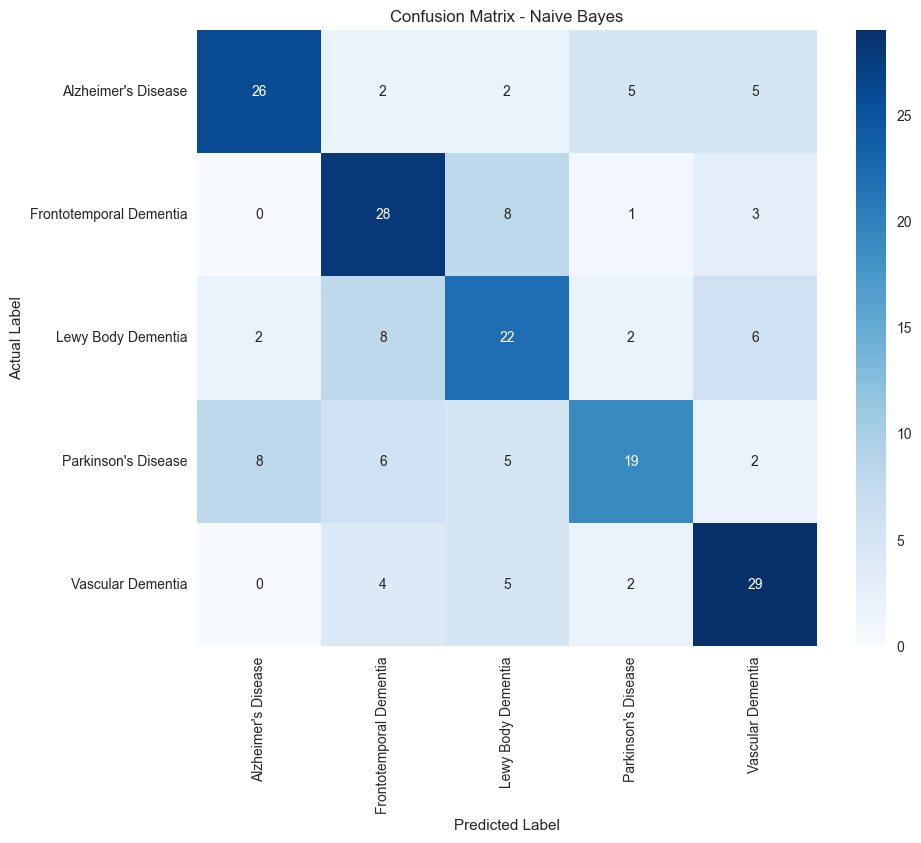

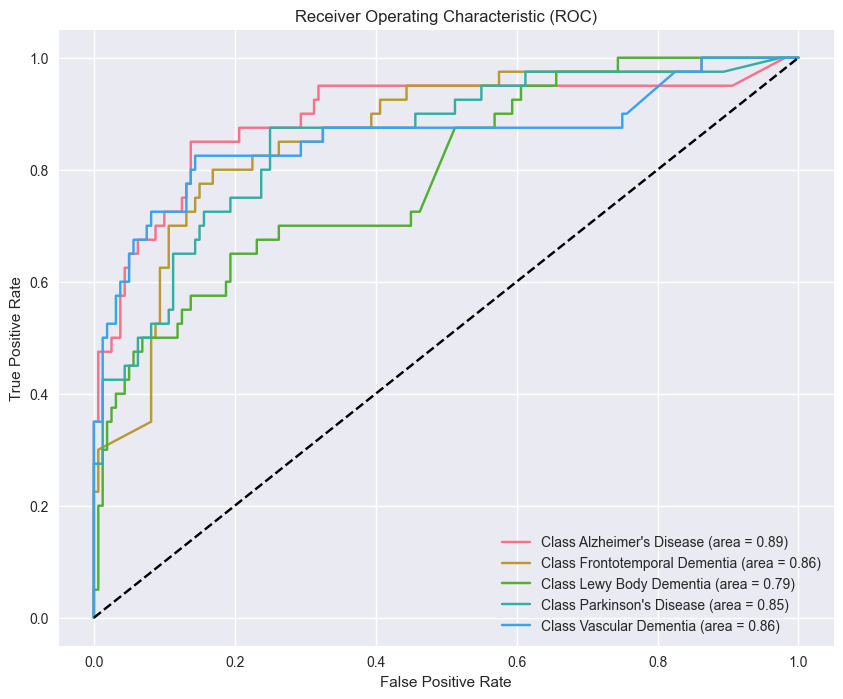

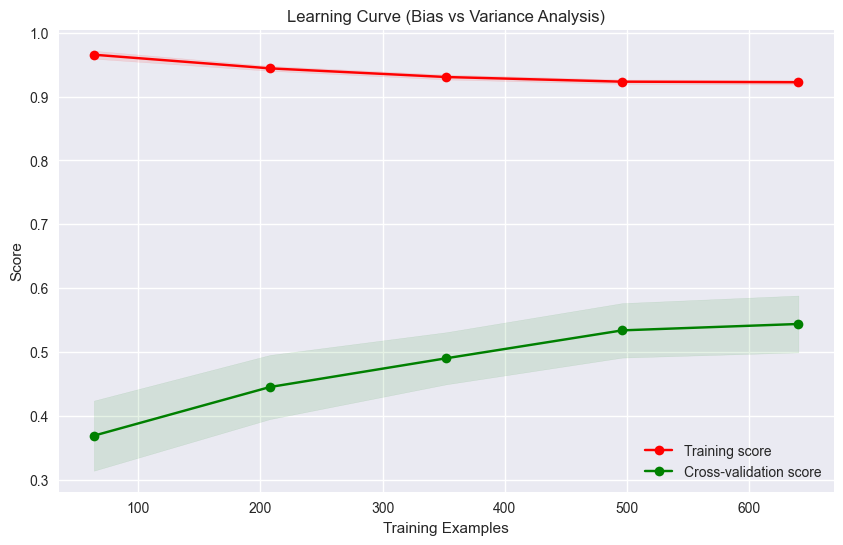


--- Error Analysis (Sample Misclassifications) ---
Total misclassified samples found: 76. Here are the first 3:
                  True_Label                Predicted  \
167      Alzheimer's Disease        Vascular Dementia   
237  Frontotemporal Dementia       Lewy Body Dementia   
892        Vascular Dementia  Frontotemporal Dementia   

                                                  Text  
167  population aging one common challenge current ...  
237  purpose evaluate diagnostic value combined sem...  
892  abstract available pad pad pad pad pad pad pad...  

--- Explainability: Top Keywords per Class ---
[Alzheimer's Disease]: ['patient', 'amyloid', 'method', 'cognitive', 'tau', 'model', 'brain', 'study', 'disease', 'pad']
[Frontotemporal Dementia]: ['tdp', 'mutation', 'variant', 'al', 'neurodegenerative', 'protein', 'study', 'patient', 'disease', 'pad']
[Lewy Body Dementia]: ['method', 'synuclein', 'clinical', 'cognitive', 'study', 'brain', 'body', 'patient', 'disease', 'pad']
[

  0%|          | 0/1 [00:00<?, ?it/s]D:\Python\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Generating Waterfall Plot for predicted class 'Vascular Dementia'...


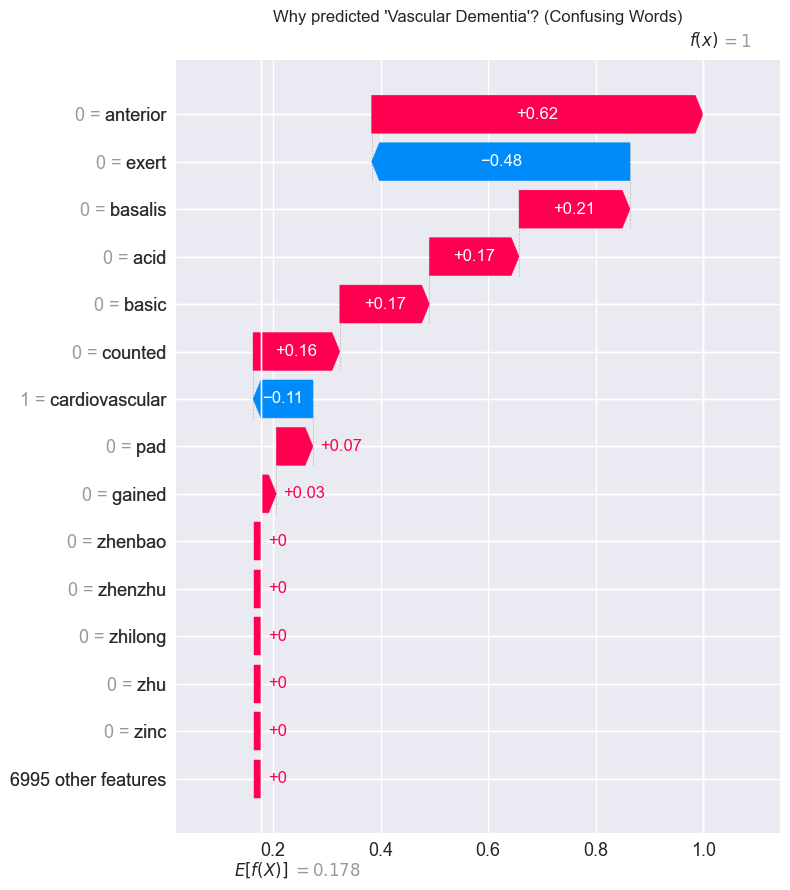


[Chart Interpretation Guide]:
1. Red bars: Words that significantly increased the probability of the WRONG prediction (Confusing Words).
2. Blue bars: Words that tried to push the prediction towards the correct label but failed.
3. Grey numbers: The frequency of the word in the text (0 means not present).


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import shap  # Ensure shap is installed: pip install shap

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. Data Loading and Preparation
# ==========================================
# Read CSV file
try:
    df = pd.read_csv('../cleaned_data.csv')
except FileNotFoundError:
    df = pd.read_csv('cleaned_data.csv')

# Ensure no empty values in text content
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

print(f"Data loading complete. Total records: {len(df)}")
print("Class Distribution:")
print(df['Label'].value_counts())

# ==========================================
# 2. Feature Engineering (Bag of Words) & Data Splitting
# ==========================================
# Split into training and testing sets (80% Train, 20% Test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# Use CountVectorizer (BoW Features)
# Using unigrams (1,1). Change to (1,2) for bigrams if needed.
vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_bow = vectorizer.fit_transform(X_train_raw)
X_test_bow = vectorizer.transform(X_test_raw)

print(f"\nVocabulary Size: {len(vectorizer.get_feature_names_out())}")

# ==========================================
# 3. Model Training (Naïve Bayes) & 10-fold CV
# ==========================================
nb_classifier = MultinomialNB()

# Perform 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_classifier, X_train_bow, y_train, cv=cv, scoring='accuracy')

print("\n--- 10-Fold Cross-Validation Results ---")
print(f"Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train model on the full training set
nb_classifier.fit(X_train_bow, y_train)

# ==========================================
# 4. Evaluation & Visualization
# ==========================================
y_pred = nb_classifier.predict(X_test_bow)

print("\n--- Test Set Evaluation ---")
print(classification_report(y_test, y_pred))

# [Chart 1] Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# [Chart 2] ROC Curve (Multi-class handling)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = nb_classifier.predict_proba(X_test_bow)

plt.figure(figsize=(10, 8))
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# ==========================================
# 5. Bias & Variability Analysis - Learning Curve
# ==========================================
train_sizes, train_scores, test_scores = learning_curve(
    MultinomialNB(), X_train_bow, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Bias vs Variance Analysis)")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid(True)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# ==========================================
# 6. Error Analysis
# ==========================================
print("\n--- Error Analysis (Sample Misclassifications) ---")
results = pd.DataFrame({'Text': X_test_raw, 'True_Label': y_test, 'Predicted': y_pred})
errors = results[results['True_Label'] != results['Predicted']]

if not errors.empty:
    print(f"Total misclassified samples found: {len(errors)}. Here are the first 3:")
    print(errors.head(3)[['True_Label', 'Predicted', 'Text']])

    # Explainability: Top Keywords per Class
    print("\n--- Explainability: Top Keywords per Class ---")
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(nb_classifier.classes_):
        top10_indices = np.argsort(nb_classifier.feature_log_prob_[i])[-10:]
        top10_words = [feature_names[j] for j in top10_indices]
        print(f"[{class_label}]: {top10_words}")

# ==========================================
# 7. Massage the Data (Control Hardship)
# Truncate text length to lower accuracy, simulating increased prediction difficulty
# ==========================================
print("\n--- Massage Data Experiment (Truncation) ---")
def massage_data_trunc(text, max_words=20):
    words = text.split()
    return ' '.join(words[:max_words])

# Create truncated dataset (keep only first 20 words per document)
df['Massaged_Content'] = df['Cleaned_Content'].apply(lambda x: massage_data_trunc(x, max_words=20))

# Re-train and evaluate
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    df['Massaged_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)
vec_m = CountVectorizer()
X_train_m_bow = vec_m.fit_transform(X_train_m)
X_test_m_bow = vec_m.transform(X_test_m)

nb_m = MultinomialNB()
nb_m.fit(X_train_m_bow, y_train_m)
acc_m = accuracy_score(y_test_m, nb_m.predict(X_test_m_bow))
print(f"Original Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy with Truncated Data (20 words): {acc_m:.4f}")
print("Conclusion: By significantly reducing available features (words), prediction difficulty was successfully increased.")

# ==========================================
# 8. SHAP Explainability Analysis (Identifying Confusing Words)
# ==========================================
print("\n--- Starting SHAP Explainability Analysis ---")

# Step A: Identify misclassified samples (Reuse 'errors' DataFrame)
# Regenerate if overwritten
results = pd.DataFrame({'Text': X_test_raw, 'True_Label': y_test, 'Predicted': y_pred})
errors = results[results['True_Label'] != results['Predicted']]

print(f"Total misclassified samples found: {len(errors)}")

if len(errors) > 0:
    # Step B: Select a specific error case
    # Taking the first error sample (iloc[0]), can be changed to check others
    error_idx = errors.index[0]

    # Find the location index of this sample in the test set matrix
    loc_idx = list(X_test_raw.index).index(error_idx)

    sample_text = errors.loc[error_idx, 'Text']
    true_label = errors.loc[error_idx, 'True_Label']
    pred_label = errors.loc[error_idx, 'Predicted']

    print(f"\n[Analyzing Sample ID: {error_idx}]")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label} (Model Error!)")

    # ---------------------------------------------------------
    # Step C: Initialize SHAP KernelExplainer
    # ---------------------------------------------------------
    print("\nInitializing SHAP KernelExplainer (This may take a minute or two)...")

    # KernelExplainer needs background data to estimate the impact of "missing features".
    # For speed, we only take the first 50 samples of the training set as background summary.
    # Note: MultinomialNB predict_proba accepts sparse matrices, but SHAP handles dense more robustly.
    background_data = X_train_bow[:50].toarray()

    # Define prediction wrapper function: input dense array -> output probability
    def predict_fn(data):
        return nb_classifier.predict_proba(data)

    explainer = shap.KernelExplainer(predict_fn, background_data)

    # Get the feature vector for the target sample (convert to dense)
    target_sample = X_test_bow[loc_idx].toarray()

    # ---------------------------------------------------------
    # Step D: Calculate SHAP Values
    # ---------------------------------------------------------
    print("Calculating SHAP Values (nsamples=100)...")
    # nsamples controls estimation precision; larger values are more accurate but slower
    shap_values = explainer.shap_values(target_sample, nsamples=100)

    # ---------------------------------------------------------
    # Step E: Intelligently Handle SHAP Values and Plot
    # ---------------------------------------------------------
    print(f"Generating Waterfall Plot for predicted class '{pred_label}'...")

    # 1. Get the index of the predicted class in the model
    pred_class_idx = list(nb_classifier.classes_).index(pred_label)

    # 2. Extract data intelligently (Compatible with both List and Array return formats from SHAP)
    sv_to_plot = None
    base_val_to_plot = None

    if isinstance(shap_values, list):
        # Case A: List format [class][sample, feature]
        sv_to_plot = shap_values[pred_class_idx][0]
        base_val_to_plot = explainer.expected_value[pred_class_idx]

    elif isinstance(shap_values, np.ndarray):
        # Case B: Array format (sample, feature, class) or (1, features)
        if len(shap_values.shape) == 3:
            sv_to_plot = shap_values[0, :, pred_class_idx]
        else:
            # Binary classification usually returns only the positive class SHAP values
            sv_to_plot = shap_values[0]

        # Handle expected_value
        if hasattr(explainer.expected_value, '__iter__'):
            base_val_to_plot = explainer.expected_value[pred_class_idx]
        else:
            base_val_to_plot = explainer.expected_value

    # 3. Plot Waterfall Chart
    if sv_to_plot is not None:
        explanation = shap.Explanation(
            values=sv_to_plot,
            base_values=base_val_to_plot,
            data=target_sample[0],
            feature_names=vectorizer.get_feature_names_out()
        )

        plt.figure(figsize=(10, 6))
        shap.plots.waterfall(explanation, max_display=15, show=False)
        plt.title(f"Why predicted '{pred_label}'? (Confusing Words)")
        plt.tight_layout()
        plt.show()

        print("\n[Chart Interpretation Guide]:")
        print("1. Red bars: Words that significantly increased the probability of the WRONG prediction (Confusing Words).")
        print("2. Blue bars: Words that tried to push the prediction towards the correct label but failed.")
        print("3. Grey numbers: The frequency of the word in the text (0 means not present).")
    else:
        print("Error: Unable to parse SHAP values data structure.")

else:
    print("No misclassified samples found for analysis.")